## Conducted Experiments (test cases)
- Arduino Chip Test with cluttered box
### Comments 
    - I used red marker with 10px to draw
    - The mask shape (binary) is weird 
    - It doesn't fully match with the box 
- Red Car Test with cluttered box
### Comments 
    - I used blue marker with 30px to draw
    - The car turns from red to blue (Magish)
    - The cropped image doesn't include the car
- Toy Keys
### Comments 
    - I used green marker with 30px to draw
    - Blue turns red and red turns blue for some fucking reason again
    - Crop is good
    - Mask is ortas ta3meya
    - Well , sifts actually match the object but draws the wrong box 
- Mobile Phone with cluttered box 
### Comments
    - I highlighted the mouse alone and it cropped it perfectly , yet the mask was habal 
    - I hightlight the mobile and it cropped it perfectly bardo , bs el mask f 7etta tanya 
    - descriptors are matching ok , but the issue is in box drawing , so we will have to consider a backup plan to evaluate according to matches accuracy
    - Masks are really werid , cropps badly due to bad contouring or bad box dimensions

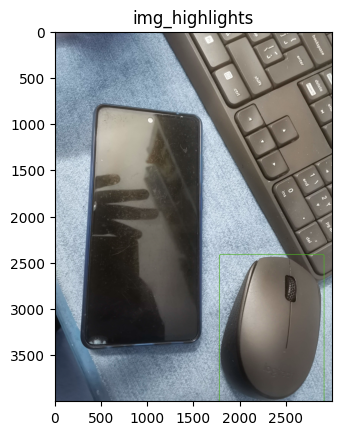

106


In [81]:
import numpy as np
import cv2
import os
from commonfunctions import *
# from cvzone.SelfiSegmentationModule import SelfiSegmentation


#img_highlights = cv2.imread("./arduino_chip_highlighted.jpg")
#img_highlights = cv2.imread("./red_car_highlighted.jpg")
#img_highlights = cv2.imread("./toy_keys_highlighted.jpg")
img_highlights = cv2.imread("./mouse_highlighted.jpg")

# img = cv2.imread("./arduino_not_highlighted.jpg")
# img = cv2.imread("./red_car.jpg")
img = cv2.imread("./mouse_mobile.jpg")

contour = cv2.subtract(img_highlights, img)
contour = cv2.cvtColor(contour, cv2.COLOR_BGR2GRAY)
# show_images([img_highlights, img, contour], ["img_highlights", "img", "contour"])
show_images([img_highlights], ["img_highlights"])
print(contour.max())
pts_contour = np.where(contour > 20)
pts_contour = np.array([pts_contour[1], pts_contour[0]]).T

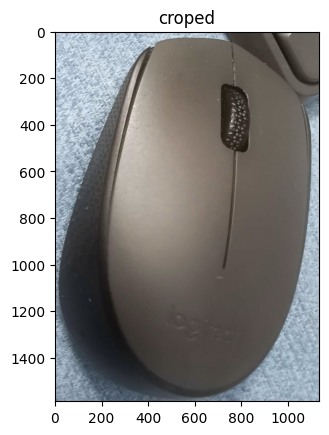

In [82]:
rect = cv2.boundingRect(pts_contour)
x, y, w, h = rect
croped = img[y : y + h, x : x + w].copy()
show_images([croped], ["croped"])

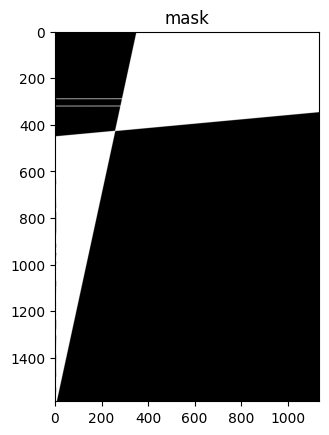

In [83]:
pts_contour = pts_contour - pts_contour.min(axis=0)

mask = np.zeros(croped.shape[:2], np.uint8)
cv2.drawContours(mask, [pts_contour], -1, (255, 255, 255), -1, cv2.LINE_AA)
# cv2.drawContours(croped, [pts_contour], -1, (0, 255, 0), 2, cv2.LINE_AA)
show_images([mask ], ["mask"])

# side note : mask el arduino bytl3 7agat 8areba

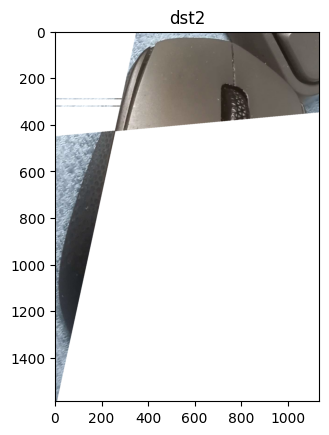

In [84]:
dst = cv2.bitwise_and(croped, croped, mask=mask)

## (4) add the white background
bg = np.ones_like(croped, np.uint8) * 255
cv2.bitwise_not(bg, bg, mask=mask)
dst2 = bg + dst
show_images([dst2], ["dst2"])

In [85]:
def applySift(train_image, test_image):
    train_image = cv2.cvtColor(train_image, cv2.COLOR_RGB2GRAY)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    kp1, desc1 = sift.detectAndCompute(train_image, None)
    kp2, desc2 = sift.detectAndCompute(test_image, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1, desc2, k=2)

    # apply test
    good = []

    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])

    img3 = cv2.drawMatchesKnn(
        train_image, kp1, test_image, kp2, good[:50], None, flags=2
    )
    show_images([img3])
    return

In [86]:
def find_matching_boxes(image, template, detector_method, params):
    """
    template: Lost object image
    image: box image
    detector_method: SIFT or ORB
    params: dictionary of parameters (max_matching_objects, SIFT_distance_threshold, best_matches_points)
    """
    # Parameters and their default values
    MAX_MATCHING_OBJECTS = params.get("max_matching_objects", 10)
    SIFT_DISTANCE_THRESHOLD = params.get("SIFT_distance_threshold", 0.7)
    BEST_MATCHES_POINTS = params.get("best_matches_points", 50)

    # Initialize the detector and matcher
    if detector_method == "SIFT":
        detector = cv2.SIFT_create()
        bf = cv2.BFMatcher()
    elif detector_method == "ORB":
        detector = cv2.ORB_create(fastThreshold=5, edgeThreshold=10)
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    else:
        raise ValueError("Unsupported detector method")

    # Find keypoints and descriptors for the template
    keypoints2, descriptors2 = detector.detectAndCompute(
        template, None
    )  # lost object image (keypoints and feature vectors)

    matched_boxes = []
    matching_img = image.copy()  # box image

    for i in range(MAX_MATCHING_OBJECTS):
        # Match descriptors
        keypoints1, descriptors1 = detector.detectAndCompute(
            matching_img, None
        )  # box image (keypoints and feature vectors)

        if detector_method == "SIFT":
            # Matching strategy for SIFT
            matches = bf.knnMatch(descriptors1, descriptors2, k=2)
            good_matches = [
                m
                for m, n in matches
                if m.distance < SIFT_DISTANCE_THRESHOLD * n.distance
            ]
            good_matches = sorted(good_matches, key=lambda x: x.distance)[
                :BEST_MATCHES_POINTS
            ]

        elif detector_method == "ORB":
            # Matching strategy for ORB
            matches = bf.match(descriptors1, descriptors2)
            matches = sorted(matches, key=lambda x: x.distance)
            good_matches = matches[:BEST_MATCHES_POINTS]

        else:
            raise ValueError("Unsupported detector method")

        # Extract location of good matches
        points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
        points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

        # Find homography for drawing the bounding box
        try:
            H, _ = cv2.findHomography(points2, points1, cv2.RANSAC, 2)
        except cv2.error:
            print("No more matching box")
            break

        # Transform the corners of the template to the matching points in the image
        h, w = template.shape[:2]
        corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(
            -1, 1, 2
        )
        transformed_corners = cv2.perspectiveTransform(corners, H)
        matched_boxes.append(transformed_corners)

        # You can uncomment the following lines to see the matching process
        # Draw the bounding box
        img1_with_box = matching_img.copy()
        matching_result = cv2.drawMatches(
            img1_with_box,
            keypoints1,
            template,
            keypoints2,
            good_matches,
            None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        )
        cv2.polylines(
            matching_result,
            [np.int32(transformed_corners)],
            True,
            (255, 0, 0),
            3,
            cv2.LINE_AA,
        )
        plt.imshow(matching_result, cmap="gray")
        plt.show()

        # Create a mask and fill the matched area with near neighbors
        matching_img2 = cv2.cvtColor(matching_img, cv2.COLOR_BGR2GRAY)
        mask = np.ones_like(matching_img2) * 255
        cv2.fillPoly(mask, [np.int32(transformed_corners)], 0)
        mask = cv2.bitwise_not(mask)
        matching_img = cv2.inpaint(matching_img, mask, 3, cv2.INPAINT_TELEA)

    return matched_boxes


# def filter_based_on_image_quality(img):
#     segmenentor = SelfiSegmentation()
#     filtered_1 = img
#     filtered_2 = img  # segmenentor.removeBG(img,(255,255,255))
#     # commonfunctions.show_images([filtered_1,filtered_2],["segmented image 1","segmented image 2"])
#     starting_k = math.sqrt(2)
#     starting_sigma = 1.5
#     X = 0
#     # previous = brisque.score(img)
#     # final = None
#     # while X < 5:
#     #     test = gaussian(filtered_1, (filtered_1,starting_k**X) * starting_sigma)
#     #     score = brisque.score(test)
#     #     if score  < previous:
#     #         final = test
#     #         previous = score
#     #     X += 1

In [87]:
pen_cluttered = dst2
pen_cluttered = cv2.cvtColor(pen_cluttered, cv2.COLOR_BGR2RGB)
pen_cluttered = cv2.resize(
    pen_cluttered, (pen_cluttered.shape[1] // 4, pen_cluttered.shape[0] // 4)
)


# commonfunctions.show_images([pen_cluttered])
# pen_copybook = cv2.imread("./box_cluttered_chip.jpg")  # Image , but erroneous image
pen_copybook = cv2.imread("./mouse_mobile.jpg")  # Image (correct box on arduino)
pen_copybook = cv2.cvtColor(pen_copybook, cv2.COLOR_BGR2RGB)
pen_copybook = cv2.resize(
    pen_copybook, (pen_copybook.shape[1] // 4, pen_copybook.shape[0] // 4)
)

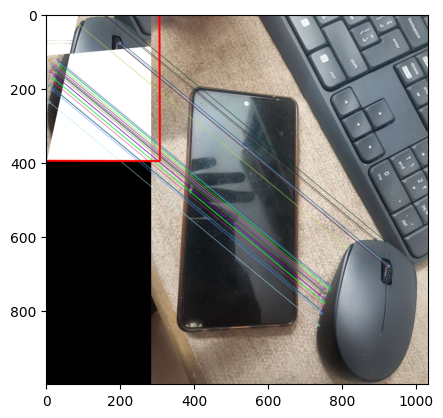

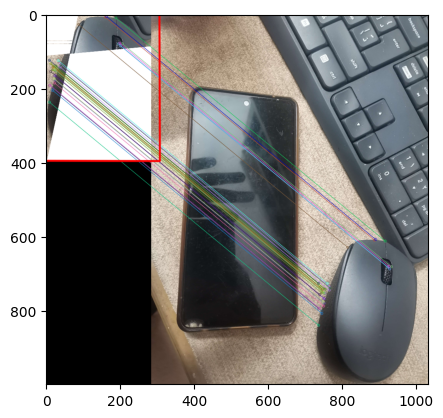

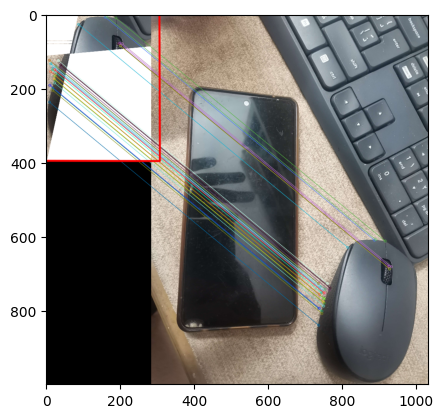

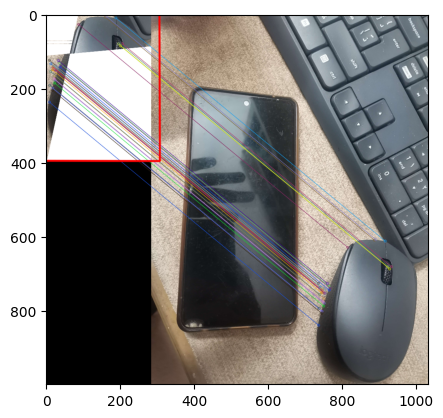

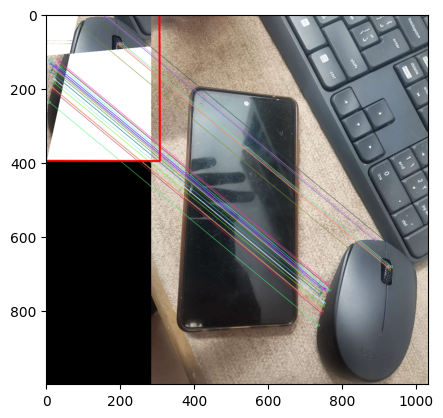

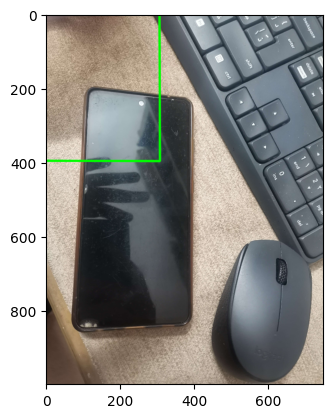

In [88]:
params = {
    "max_matching_objects": 5,
    "SIFT_distance_threshold": 0.7,
    "best_matches_points": 50,
}

matched_boxes = find_matching_boxes(pen_cluttered, pen_copybook, "SIFT", params)

# Draw the bounding boxes on the original image
for box in matched_boxes:
    cv2.polylines(pen_copybook, [np.int32(box)], True, (0, 255, 0), 3, cv2.LINE_AA)

plt.imshow(pen_copybook)
plt.show()

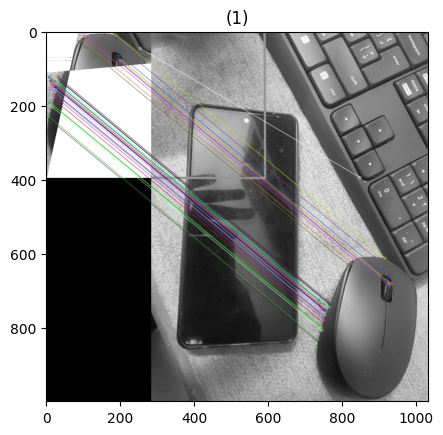

In [89]:
applySift(pen_cluttered, pen_copybook)